# Bayesian Treatment and Response

In this notebook we outline a method for estimating treatment response models using Bayesian methods. We focus initially on the discrete-treatment-continuous-response: some cases receive a treatment (belong to a union, receive training, smoke, etc.), while some do not. For each group we have a continuous measure of outcomes (i.e., wages, child birthweight). 

Why Bayesian methods? Why not just stick with the same old classical methods? Some reasons:

1. Bayesian methods place a lot of structure on the data generation process but also allow one to fully characterize standard errors. Hence, they can be pretty good in small samples. 
2. Bayesian methods allow one to say something about things like correlation across outcomes that are typically not observable.
3. Bayesian methods also generate some things like individual-level treatment effects just as a by-product of estimation.
4. Bayesian methods avoid optimization and instead draw samples from the distribution of parameters implied by the data. This can be a great advantage in situations in which optimization is difficult.
5. Bayesian methods allow inclusion of prior information or beliefs about parameters. One area in which this is relevant in the treatment context: beliefs about independence of outcomes and treatment.


# The basic model and theory

There are treatment and control groups, and a set of covariates. The model is essentially a switching regression, where agents select into different groups in part based on things we observe about them and maybe on some things we do not. 

Treatment is a dichotomous variable $z = \{0,1\}$, and we observe $z=1$ if some underlying latent variable $z^*$, is greater than zero, $z=0$ otherwise. 

We have a Probit-like model selection into treatment  :
$$
z^* = \eta W + \epsilon_z
$$
And 
$$ \begin{array}{ccc}
z = 1 & \textrm{if} & z^* = \eta W + e_z > 0 \\
z = 0 & \textrm{otherwise} &
\end{array}
$$
where we assume that $e_z \sim N(0,1)$. 

Outcome equations differ based on whether or not the individual is treated. If $z=1$, the following equation explains the outcome $y$:
$$
y_1 = X\beta_1 + e_1, \quad z=1, \quad e_1 \sim N(0,\sigma_1^2)
$$
$$
y_0 = X\beta_0 + e_0, \quad z=0 \quad e_0 \sim N(0,\sigma_0^2)
$$

## Point of interest

In observational data, we never actually observe both outcomes for a given individual. I.e., we don't see what happens to a patient if he or she both takes and does not take a medication or we don't see what happens if someone both does and does not join a union. But a Bayesian method allows us to consider this as well - the idea is to treat the unobserved outcome as yet another latent variable that is estimated/simulated along with everything else. 

The variance matrix for $y_1,y_0$, and $z$ is:

$$
\Sigma = \left[
\begin{array}{ccc}
\sigma_1^2  & \sigma_{10} & \sigma_{1z} \\
                                   & \sigma_0^2 & \sigma_{0z} \\
                                   &      &  1 
\end{array}
\right]
$$
We have to also assume that $\sigma_z=1$ because of the indeterminacy of the scale parameter in a probit model. If this model is to be estimated using classical methods, one usually has to assume that $\sigma_{10}=0$, as there is no basis for estimating it - one has to observe both $y_1$ and $y_0$. But this is never the case in observational data (we don't see what happens to a work when they are in a union and not in a union!). 

## Key Idea: Gibbs sampling

The critical tool used in estimation is Gibbs sampling. Suppose we have a multivariate distribution $f(x_1,x_2)$ we wish to sample from. Gibbs sampling says that we can draw from this distribution conditionally and sequentially to get draws from the overall joint distribution. 

That is, we can take $x_2$ given, and then draw $x_1$ from the conditional distribution $f(x_1|x_2)$. Now that we have an $x_1$, we can draw $x_2$ from $f(x_2|x_1)$. Now we have another value of $x_2$, so we can get another draw $x_1$ from the new $f(x_1|x_2)$ and so on. It can be shown (but it's not that easy!) that this method eventually produces draws $(x_1,x_2)$ from the joint distribution $f(x_1,x_2)$. 

This tool is more useful than one might think at first glance because a lot of applications have the property that $f(x_1,x_2)$ is very complicated, but $f(x_1|x_2)$ and $f(x_2|x_1)$ are extremely simple.

# Methods of estimation

## Description of a Gibbs sampler

If we wanted to write the full likelihood of the data, it might consist of three parts: a probit style likelihood describing treatment or not, and then a likelihood for the outcome conditional on treatment. This is tricky in the current setting because we have a trivariate normal distribution, and what can be thought of as two latent variables - the threshold variable for treatment, and the value of whatever is unobserved. This is tough (but not impossible) - Heckman and coauthors have some papers describing methods for dealing with these problems. But we will go directly to the Gibbs sampler.

## Gibbs sampler

To design a Gibbs sampler, one just has to think about the conditional distribution of one thing when everything else is given. Heuristically, my idea is to proceed as follows:

1. Given $\beta,\eta,\Sigma, X,y_0$, draw values for $y_1$. That is, draw a treatment outcome for those who were not treated (z = 0). This is fairly simple, as $y$ is univariate normal conditional on everything else (all other data and parameters) is given.

2. Given $\beta,\eta,\Sigma, X,y_1$, draw values for $y_0$. That is, draw a non-treated outcome for those who were treated (z=1). Same as previous: univariate normal.

3. Given $\eta,\Sigma, W,y_0,y_1,z$, draw values for $z^*$, the unobserved latent variable describing selection into treatment. $z^*$ is univariate truncated normal; we require $z^*>0$ if treated, $z^*<0$ if not. 

4. Given $\Sigma, X,y_0,y_1,z$ draw values for $\beta_0$. $\beta_0$ is multivariate normal, basically in the same fashion as the typical regression.

5. Given $\Sigma,X,y_0,y_1,z$ draw values for $\beta_1$. Same as 4.

6. Draw values for the 5 terms in $\Sigma$. This is a bit more complicated, and we use a Markov chain Monte Carlo method for this.  

Almost everything here just requires a normal distribution. Number 6 is a little more complicated, but we can use a Markov-chain Monte carlo Metropolis-within-Gibbs step for that. The key formula needed is that of the conditional normal. If we want to know the distribution of some subset $y_1$ given $y_2$, when mean vectors are $\mu_1, \mu_2$ and the variance matrix is $\Sigma$, we use:

\begin{equation*}
\Sigma = \left[ \begin{array}{c|c}
\Sigma_{11} & \Sigma_{12} \\
\hline
\Sigma_{21} & \Sigma_{22}
\end{array}\right]
\end{equation*}

The conditional mean of $y_1$ given $y_2$ is:
\begin{equation*}
E[y_{1|2}] = \mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(y_2 - \mu_2) 
\end{equation*}
and the conditional variance of $y_1$ given $y_2$ is:
\begin{equation*}
V[y_{1|2}] = \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21} 
\end{equation*}



**Step 1:**

Use $\mu_1=X\beta_1$, $\mu_2=X\beta_0, W\eta$, $y_2=y_0, z$, $\Sigma_{12} = \Sigma_{21}' =\left[\sigma_{10},\sigma_{1z}\right]$,
and
\begin{equation*}
\Sigma_{22}=\left[\begin{array}{cc}\sigma_0^2 & \sigma_{0z} \\ \sigma_{0z} & 1 \end{array} \right]
\end{equation*}





**Step 2:**

Use $\mu_0=X\beta_0$, $\mu_2=[X\beta_1,W\eta]$, $y_2=[y_1, z]$, $\Sigma_{12} = \Sigma_{21}' =\left[\sigma_{10},\sigma_{0z}\right]$,
and
\begin{equation*}
\Sigma_{22}=\left[\begin{array}{cc}\sigma_1^2 & \sigma_{1z} \\ \sigma_{1z} & 1 \end{array} \right]
\end{equation*}


**Step 3: **

Use $\mu_1 = W\eta$, $\mu_2=[X\beta_1,X\beta_0]$, $y_2=[y_1, y_0]$, $\Sigma_{12} = \Sigma_{21}' =\left[\sigma_{1z},\sigma_{0z}\right]$,
and
\begin{equation*}
\Sigma_{22}=\left[\begin{array}{cc}\sigma_1^2 & \sigma_{10} \\ \sigma_{10} & \sigma_0^2 \end{array} \right]
\end{equation*}

But note that draws must be from a truncated random normal variable, where if $z=1$, data is left-truncated at 0, and if $z=0$ data is right-truncated at 0.

** Step 4/5/6: **

We now have all the data that we need and all we have to do is transform the dependent variables so that they are purged of cross equation correlation. That is, we remove cross-variable correlation from $y_1,y_0,$ and $z$ and then observe that:
\begin{equation*}
\beta_1 \sim N\left[ (X'X)^{-1}X'\hat{y}_1, \sigma_{1}^2(X'X)^{-1} \right]
\end{equation*}
Similarly:
\begin{equation*}
\beta_0 \sim N\left[ (X'X)^{-1}X'\hat{y}_0, \sigma_{0}^2(X'X)^{-1} \right]
\end{equation*}
and finally
\begin{equation*}
\eta \sim N\left[ (W'W)^{-1}W'\hat{z}, (W'W)^{-1}\right]
\end{equation*}





To provide a bit more detail about what $\hat{y}_1$ looks like, for example, we see that when $y_1$ is being drawn, the $\Sigma$ matrix partitions as follows:

\begin{equation*}
\Sigma = \left[ \begin{array}{c|c}
\sigma_1^2 & \begin{array}{cc} \sigma_{10} & \sigma_{1z} \end{array} \\
\hline
\begin{array}{c}
\sigma_{10} \\
\sigma_{1z} \end{array}& \begin{array}{cc} \sigma_{0}^2 & \sigma_{0z} \\ \sigma_{0z} & 1 \end{array}
\end{array}\right]
\end{equation*}

the formula for $\hat{y}_1$ is:

\begin{equation*}
\hat{y}_1 = X\beta_1 +\Sigma_{12}\Sigma_{22}^{-1}*(y_0-X\beta_0, z-\eta W)
\end{equation*}

But since we have: $\Sigma_{12} = \left[\sigma_{10}, \sigma_{1z}\right]$, and can compute

\begin{equation*}
\Sigma_{22}^{-1} = \left[\begin{array}{cc} \frac{1}{\sigma_0^2-\sigma_{0z}^2}& -\frac{\sigma_{0z}}{\sigma_0^2-\sigma_{0z}^2}\\ -\frac{\sigma_{0z}}{\sigma_0^2-\sigma_{0z}^2}&\frac{\sigma_0^2}{\sigma_0^2-\sigma_{0z}^2} \end{array} \right]
\end{equation*}

# Typical Metropolis-Hastings draw

The basic idea behind a Metropolis-Hastings draw is to look a ratio of two values of a function, and then accept based on this. That is, suppose we have a given value of $x$, $x_0$. We have some measure of how likely $x_0$ is, say $f(x_0)$. This value may be imcomplete in the sense that is is not a correct density that integrates to one and all that. In fact, it can be almost anything! Now, by some means, we produce a draw $x_1$. The MH algorithm says we should compute the ratio:

\begin{equation*}
\alpha = \frac{f(x_0)}{f(x_1)}
\end{equation*}

and then accept the draw $x_1$ as the new value of $x$ with probability $r$. Mechanically, we draw a uniform random variable $u$ and accept if $u<r$. Otherwise, we just keep $x_0$ as the given draw. It's weird, but it works (again, not all that easy to show)!

# Detailed Example

We will work with a stock Stata data set and use the `ipystata` interface. Here, we use the classic union data set and try to get a feel for the impact of union membership on wages. So, in this case, our treatment variable is `union` and our outcome variable is the wage. We shall use the variable `south` as an instrument (it will be in the equation predicting union membership but not in the wage equation), but it is worth asking: what happens if we don't believe that our instrument is all that good?  

Initially, we are going to take it very slow and worry about how initial draws are produced, and think about how each step works. At the end of this, we are going to write a program to a `.do` file that will speed things up a little bit. 

In [2]:
import ipystata

In [3]:
%%stata
clear all 
use http://www.stata-press.com/data/r13/union3
set more off
keep if union != . 
keep if tenure != .
describe 
set seed 5150


(National Longitudinal Survey.  Young Women 14-26 years of age in 1968)

(449 observations deleted)

(34 observations deleted)

Contains data from http://www.stata-press.com/data/r13/union3.dta
  obs:         1,210                          National Longitudinal Survey.  Young Women 14-26 years of age in 1968
 vars:            24                          11 Mar 2013 09:47
 size:        55,660                          
-------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
-------------------------------------------------------------------------------------------------------------------------------------------------------------
idcode          int     %8.0g                 NLS ID
year            byte    %8.0g                 interview year
birth_yr        byte    %8.0g                 

## Simple regressions and a Probit

The first thing that we want to do is just run some simple regressions, and a probit for selection into "treatment" which is here belonging to a union. In fact, we will take these as the initial values for our Bayesian estimation procedure. So:

In [4]:
%%stata
reg wage age grade smsa black tenure if union == 1
mat binit1 = e(b)

reg wage age grade smsa black tenure if union == 0
mat binit0 = e(b) 

probit union south black tenure
mat einit = e(b)



      Source |       SS           df       MS      Number of obs   =       253
-------------+----------------------------------   F(5, 247)       =     18.89
       Model |  419.610641         5  83.9221281   Prob > F        =    0.0000
    Residual |  1097.48439       247  4.44325665   R-squared       =    0.2766
-------------+----------------------------------   Adj R-squared   =    0.2619
       Total |  1517.09503       252  6.02021838   Root MSE        =    2.1079

------------------------------------------------------------------------------
        wage |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         age |   .1562246   .0492065     3.17   0.002     .0593067    .2531425
       grade |   .3897226    .062765     6.21   0.000     .2660997    .5133456
        smsa |    1.10633   .3384687     3.27   0.001     .4396772    1.772983
       black |  -.9184192   .2896539    -3.17   0.

## Steps in Bayesian Estimation

Now, we pull all the variables that we need into `Mata`, and some constants to get the full-blown vectors we need, and at the same time, we pull in the initial values from the regressions to be used. We also set logs of variances at zero, and set all covariance terms at 0 too.

In [5]:
%%stata --mata
    st_view(y=., ., "wage")
    st_view(tr=., ., "union")
    st_view(X=., ., "age grade smsa black tenure")
    st_view(W=., ., "south black tenure")
    X = X, J(rows(y), 1, 1)
    W = W, J(rows(y), 1, 1)

    b1 = st_matrix("binit1")        
    b0 = st_matrix("binit0")
    e = st_matrix("einit")

    nb = cols(b1)
    ne = cols(e)

    lnsd1 = 0                      
    lnsd0 = 0
    v10   = 0
    v1t   = 0
    v0t   = 0

Mata output:




## Some requireed functions 

### Robust `invnormal` function

One further thing we need to do is make a more stable inverse-normal function. This is because if a normal probability winds up being either one or zero, the stock `invnormal` function will return a missing and it is helpful to avoid this possibility in advance, as it can wreak havok with everything.

### Joint likelihood function

We also create a function that takes error terms $y-\mu$ and a variance matrix $\Sigma$, and calculates the joint likelihood of all the data based on these things. We will use this when drawing values for the variance matrix. That is, we will take a proposal value of, say, $\sigma_{10}$ and calculate $LL(\Sigma)$ at this value. We will compare this to an existing value using a Metropolis-Hastings step as described above.

In [6]:
%%stata --mata
    real matrix invnormstab(X) {
        XHat = editvalue(X, 0, 1e-323)
        XHat = editvalue(XHat, 1, 1e-16 )
        return(XHat)
    }
    real scalar ln_L(real matrix errs, real matrix Sigma) {
        part1 = -cols(errs)*rows(errs)/2*ln(2*pi())
        part2 = -1/2*colsum(rowsum( (errs*invsym(Sigma):*errs)))
        part3 = -rows(errs)/2*ln(det(Sigma))
        return(part1 + part2 + part3)
    }

Mata output:




### Simple initial values

While we understand that one has to compute variances conditionally, to get started we really just need some values of latent variables that are in the ballpark. So, we draw these as follows:


In [7]:
%%stata --mata
    y0Hat = X*b0' + rnormal(rows(y),1,0,1)*exp(lnsd0)
    y1Hat = X*b1' + rnormal(rows(y),1,0,1)*exp(lnsd1)
    y1 = tr:*y + (1 :- tr):*y1Hat
    y0 = (1 :- tr):*y + tr:*y0Hat

    muz = W*e'
    et  = invnormstab( normal(-muz) + (1 :- normal(-muz)):*runiform(rows(muz),1) )
    ent = invnormstab( normal(-muz):*runiform(rows(muz),1) )
    z = muz + et:*tr + ent:*(1 :- tr)
    
    m0 = X*b0'
    m1 = X*b1'
    mt = W*e'
    ey1 = (y1 - m1)
    ey0 = (y0 - m0)
    et  = (z - mt)

Mata output:




Now, we make some placeholders for parameters, also put some prior distributions into action. We also calculate the symmetric inverse of $X'X$ and $W'W$, as these things never change so there is no great reason to keep calculating them as we run through the iterations!

In [8]:
%%stata --mata
    b1Hold        = b1
    b0Hold        = b0
    eHold         = e
    sd1Hold       = lnsd1
    sd0Hold       = lnsd0
    v10Hold       = v10
    v1tHold       = v1t
    v0tHold       = v0t

    draws = 1000
    
    XX = invsym(X'X)
    WW = invsym(W'W)

Mata output:




## Draws of a latent variable - illustration

While draws typically follow what we did above, it is helpful to just see how a typical draw and update goes for our $y_1$ variable. In this case, we have to compute the sub-matrices of $\Sigma$, calculate conditional means, and then draw. Finally, we will update the error vector. The whole thing looks a little something like this:


In [9]:
%%stata --mata

    Sig12 = (v10, v1t)                                      //Compute Sigma[12] for y1
    Sig22 = exp(lnsd0)^2, v0t \ v0t, 1                      //Compute Sigma[22] for y1
    Sig22m1 = invsym(Sig22)                                 //Invert Sigma[22]

    CM = rowsum( (Sig12*Sig22m1):*(ey0, et) )               //This is Sigma[12]*S[22]^-1*[(y0,z)-(my0,mz)] in parallel
    CV = exp(lnsd1)^2 - Sig12*Sig22m1*Sig12'                //variance of y1 conditional on y0, 

    mc1   = X*b1' + CM                                      //Mean of y1 conditional on y0,z
    y1Hat = mc1 + rnormal(rows(y),1,0,1)*sqrt(CV)           //Drawing y1 from conditional distribution
    y1    = tr:*y + (1 :-tr):*y1Hat                         //Replacing y1 with draws but only if y1 not observed

    mb1 = XX*X'(y1 - CM)                                    //mean(b1) = (X'X)^{-1}(X'y1) y1 is purged of dependence on y0,z 
    vb1 = CV*XX                                             //Var(b1)
    b1 = mb1 + cholesky(vb1)*rnormal(cols(b1), 1, 0, 1)     //Drawing new b1, given mean and variance
    b1 = b1'                                                //row to column vector

    m1 = X*b1'                                              //computation of new deviations from mean
    ey1 = (y1 - m1)

Mata output:




In [10]:
%%stata --mata
b1

Mata output:

                  1              2              3              4              5              6
    +-------------------------------------------------------------------------------------------+
  1 |   .1525796931    .3966710577    1.151345935   -.8960741013    .1540438274    -2.88723905  |
    +-------------------------------------------------------------------------------------------+



# Typical MCMC - Metropolis-Hastings draw

Here is what a draw of a typical variable that we don't know the distribution for might look like. In the case below, we are drawing the log-standard deviation of the outcome among the treated: $ln(\sigma_1)$. Note that as a practical matter, we need a few things such as a proposal value `prosd1`, a damping paramter `gam`, and a target acceptance rate `asta`. 

Below is one step in an adaptive MCMC algorithm (for more details, one can consult [Baker, 2015](http://www.stata-journal.com/article.html?article=st0354). The idea is that we are trying to tune the draws so that they are accepted at the rate $a^*$. This is done by increasing the propsal standard deviation whenever a draw is accepted, and decreasing it whenever one is rejected. 

In [11]:
%%stata --mata
    prosd1 = 1                                                                   //Standard dev. for proposal
    gam   = 1                                                                       //Damping parameter
    asta = .4                                                                    //Acceptance rate target
    delta = 1

    lnsd1Hat = lnsd1 + rnormal(1,1,0,1)*prosd1                                   //Draw from normal with mean=previous draw
    Sigma    = exp(lnsd1)^2,   v10, v1t \ v10, exp(lnsd0)^2, v0t \ v1t, v0t, 1   //Constructing existing variance matrix
    SigmaHat = exp(lnsd1Hat)^2,v10, v1t \ v10, exp(lnsd0)^2, v0t \ v1t, v0t, 1   //Proposed variance matrix with new lnsd1

    if ( hasmissing(cholesky(SigmaHat)) == 0 ) {                                 //Reject if new variance mat is not posdef
        val    = ln_L((ey1, ey0, et), Sigma)                                     //Compute data likelihood at old Sigma
        valHat = ln_L((ey1, ey0, et), SigmaHat)                                  //Compute data likelihood at new Sigma
        rat = valHat - val                                                       //Log ratio of two values.
        alpha = min((exp(rat), 1))                                               //alpha is actual ratio
        if (runiform(1,1,0,1) < alpha) lnsd1 = lnsd1Hat                          //accept draw with prob. alpha
            prosd1 = exp(gam*(alpha - asta))*prosd1                              //adjust proposal dist. up or down 
    }
    else {
        prosd1 = exp(-asta*gam)*prosd1                                           //adjustment if rejected due to nonposdef
    }

Mata output:




### Proposal parameters

The last thing we need are some proposal variances. That is, when drawing new values for $\sigma_{10}$ say, we need some distribution from which to get these values. We will start with a proposal standard deviation of one and tune it up or down to get a sufficient number of draws. Here are these parameters:

In [12]:
%%stata --mata
    prosd1 = 1
    prosd0 = 1
    prov10 = 1
    prov1t = 1
    prov0t = 1
    draws = 10000

Mata output:




We now have enough to put together a whole loop, and estimate parameters via a full-blown Bayesian approach. First, we make a few placeholders to hold the draws:

## The complete loop

And here is the complete loop following the Gibbs sampling outlined above. 

In [13]:
%%stata --mata
for (i=1;i<=10000;i++) {

    Sig12 = (v10, v1t)
    Sig22 = exp(lnsd0)^2, v0t \ v0t, 1
    Sig22m1 = invsym(Sig22)

    CM = rowsum( (Sig12*Sig22m1):*(ey0, et) )
    CV = exp(lnsd1)^2 - Sig12*Sig22m1*Sig12'

    mc1   = m1 + CM
    y1Hat = mc1 + rnormal(rows(y),1,0,1)*sqrt(CV)
    y1    = tr:*y + (1 :-tr):*y1Hat
    
    mb1 = XX*X'(y1 - CM)
    vb1 = CV*XX
    b1 = mb1 + cholesky(vb1)*rnormal(cols(b1), 1, 0, 1)
    b1 = b1'

    m1 = X*b1'
    ey1 = (y1 - m1)

    Sig12 = (v10, v0t)
    Sig22 = exp(lnsd1)^2, v1t \ v1t, 1
    Sig22m1 = invsym(Sig22)
    
    CM = rowsum( (Sig12*Sig22m1):*(ey1, et) )
    CV = exp(lnsd0)^2 - Sig12*Sig22m1*Sig12'
    
    mc0   = m0 + CM
    y0Hat = mc0 + rnormal(rows(y),1,0,1)*sqrt(CV)
    y0 = (1 :- tr):*y + tr:*y0Hat
        
    mb0 = XX*X'(y0 - CM)
    vb0 = CV*XX
    b0 = mb0 + cholesky(vb0)*rnormal(cols(b0), 1, 0, 1)
    b0 = b0'

    m0 = X*b0'
    ey0 = (y0 - m0)	
    
    Sig12 = (v1t, v0t)
    Sig22 = exp(lnsd1)^2, v10 \ v10, exp(lnsd0)^2
    Sig22m1 = invsym(Sig22)

    CM = rowsum( (Sig12*Sig22m1):*(ey1, ey0) )
    CV = 1 - Sig12*Sig22m1*Sig12'
    
    mct = mt + CM
    et  = CV*invnormstab( normal(-mct/CV) + (1 :- normal(-mct/CV)):*runiform(rows(mct),1) )
    ent = CV*invnormstab( normal(-mct/CV):*runiform(rows(mct),1) )
    z = mct + et:*tr + ent:*(1 :- tr)

    meane = WW*W'(z - CM)
    vare  = CV*WW
    e = meane + cholesky(vare)*rnormal(cols(e), 1, 0, 1)
    e = e'
    
    mt = W*e'
    et = (z - mt)

    gam = 1/i^delta

    lnsd1Hat = lnsd1 + rnormal(1,1,0,1)*prosd1
    Sigma    = exp(lnsd1)^2,   v10, v1t \ v10, exp(lnsd0)^2, v0t \ v1t, v0t, 1
    SigmaHat = exp(lnsd1Hat)^2,v10, v1t \ v10, exp(lnsd0)^2, v0t \ v1t, v0t, 1 

    if ( hasmissing(cholesky(SigmaHat)) == 0 ) {
        val    = ln_L((ey1, ey0, et), Sigma)
        valHat = ln_L((ey1, ey0, et), SigmaHat)
        rat = valHat - val
        alpha = min((exp(rat), 1))
        if (runiform(1,1,0,1) < alpha) lnsd1 = lnsd1Hat
        prosd1 = exp(gam*(alpha - asta))*prosd1
    }
    else {
        prosd1 = exp(-asta*gam)*prosd1
    }
    
    lnsd0Hat = lnsd0 + rnormal(1,1,0,1)*prosd0
    Sigma    = exp(lnsd1)^2, v10, v1t \ v10, exp(lnsd0)^2,    v0t \ v1t, v0t, 1
    SigmaHat = exp(lnsd1)^2, v10, v1t \ v10, exp(lnsd0Hat)^2, v0t \ v1t, v0t, 1 

    if ( hasmissing(cholesky(SigmaHat)) == 0 ) {
        val    = ln_L((ey1, ey0, et), Sigma)
        valHat = ln_L((ey1, ey0, et), SigmaHat)
        rat = valHat - val
        alpha = min((exp(rat), 1))
        if (runiform(1,1,0,1) < alpha) lnsd0 = lnsd0Hat
        prosd0 = exp(gam*(alpha - asta))*prosd0
    }
    else {
        prosd0 = exp(-asta*gam)*prosd0
    }

    v10Hat = v10 + rnormal(1,1,0,1)*prov10
    Sigma    = exp(lnsd1)^2, v10,    v1t \ v10,    exp(lnsd0)^2, v0t \ v1t, v0t, 1
    SigmaHat = exp(lnsd1)^2, v10Hat, v1t \ v10Hat, exp(lnsd0)^2, v0t \ v1t, v0t, 1 

    if ( hasmissing(cholesky(SigmaHat)) == 0 ) {
        val    = ln_L((ey1, ey0, et), Sigma)
        valHat = ln_L((ey1, ey0, et), SigmaHat)
        rat = valHat - val
        alpha = min((exp(rat), 1))
        if (runiform(1,1,0,1) < alpha) v10 = v10Hat
        prov10 = exp(gam*(alpha - asta))*prov10
    }
    else {
        prov10 = exp(-asta*gam)*prov10
    }


    v1tHat = v1t + rnormal(1,1,0,1)*prov1t
    Sigma    = exp(lnsd1)^2, v10, v1t    \ v10, exp(lnsd0)^2, v0t \ v1t,    v0t, 1
    SigmaHat = exp(lnsd1)^2, v10, v1tHat \ v10, exp(lnsd0)^2, v0t \ v1tHat, v0t, 1 

    if ( hasmissing(cholesky(SigmaHat)) == 0 ) {
        val    = ln_L((ey1, ey0, et), Sigma)
        valHat = ln_L((ey1, ey0, et), SigmaHat)
        rat = valHat - val
        alpha = min((exp(rat), 1))
        if (runiform(1,1,0,1) < alpha) v1t = v1tHat
        prov1t = exp(gam*(alpha - asta))*prov1t
    }
    else {
        prov1t = exp(-asta*gam)*prov1t
    }
    
    v0tHat = v0t + rnormal(1,1,0,1)*prov0t
    Sigma    = exp(lnsd1)^2, v10, v1t \ v10, exp(lnsd0)^2, v0t    \ v1t, v0t,    1
    SigmaHat = exp(lnsd1)^2, v10, v1t \ v10, exp(lnsd0)^2, v0tHat \ v1t, v0tHat, 1 

    if ( hasmissing(cholesky(SigmaHat)) == 0 ) {
        val    = ln_L((ey1, ey0, et), Sigma)
        valHat = ln_L((ey1, ey0, et), SigmaHat)
        rat = valHat - val
        alpha = min((exp(rat), 1))
        if (runiform(1,1,0,1) < alpha) v0t = v0tHat
        prov0t = exp(gam*(alpha - asta))*prov0t
    }
    else {
        prov0t = exp(-asta*gam)*prov0t
    }

    b1Hold = b1Hold \ b1
    b0Hold = b0Hold \ b0
    eHold = eHold \ e
    
    sd1Hold = sd1Hold \ lnsd1
    sd0Hold = sd0Hold \ lnsd0
    v10Hold = v10Hold \ v10
    v1tHold = v1tHold \ v1t
    v0tHold = v0tHold \ v0t	

}

Mata output:




# Analysis

Now that we have draws, what do we do with them? And how do we know they make any sense? A first thing we might do is pull all the draws into Stata, look at distributions, plots, etc. Accordingly:

In [14]:
%%stata

preserve
clear

getmata (b1*) = b1Hold
getmata (b0*) = b0Hold
getmata (e*)= eHold
getmata (sd1*) = sd1Hold
getmata (sd0*) = sd0Hold 
getmata (v10*) = v10Hold
getmata (v1z*) = v1tHold 
getmata (v0z*) = v0tHold

Sum basic summary statistics will see if our results are reasonable:

In [15]:
%%stata
sum b1*
mat list binit1


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
         b11 |     10,001    .1727532    .0035003   .0832466   .1761999
         b12 |     10,001    .4216258     .005329   .3718441   .5127503
         b13 |     10,001    .9856846    .0165845   .7300177   1.437507
         b14 |     10,001   -.5463304    .0197068  -.9731398   -.514671
         b15 |     10,001    .0889649     .006311   .0818366   .2386424
-------------+---------------------------------------------------------
         b16 |     10,001   -3.291759    .1266582  -3.856908  -1.682377

binit1[1,6]
           age       grade        smsa       black      tenure       _cons
y1   .15622459   .38972261   1.1063302  -.91841921   .15211855  -2.8141755



In [16]:
%%stata
sum b0*
mat list binit0

sum e*
mat list einit


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
         b01 |     10,001    .1372905    .0021235   .1070977    .186445
         b02 |     10,001    .4359551    .0037522   .4042758   .4896391
         b03 |     10,001    .9484694    .0178264   .8033673   1.171998
         b04 |     10,001   -.4420672    .0323099  -.6862444  -.3406544
         b05 |     10,001    .2152341    .0054823   .1707931   .2786145
-------------+---------------------------------------------------------
         b06 |     10,001   -4.030201    .0771457  -5.141699  -3.309731

binit0[1,6]
           age       grade        smsa       black      tenure       _cons
y1   .14527947   .45528082   .95445704  -.52508486   .22778787  -4.5354845

    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
          e1 |     10,001    -.723386    .0


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        sd11 |     10,001    .3316464    .0075127          0    .398085
        sd01 |     10,001    .5006957    .0090323          0   .5468315
        v101 |     10,001    1.371981    .0525939          0   1.374211
        v1z1 |     10,001    -.488017    .0172037  -.4886895   .0567256
        v0z1 |     10,001    .8921683    .0279825          0   .8931655



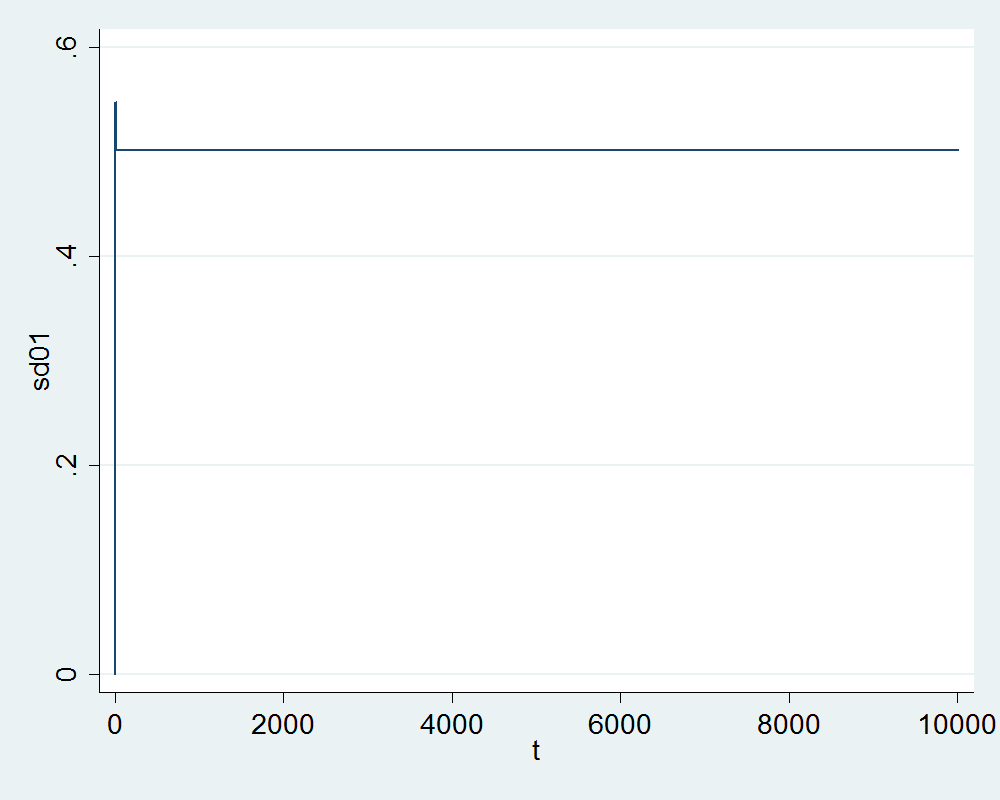

In [22]:
%%stata -gr
sum sd1 sd0 v10 v1z v0z
tsline sd0 